#Bat AGN Exploratory Analysis: Casey 2012 Model Fits

This notebook takes a look at the fitting results for the BAT AGN using the model from Casey 2012.

Prior distributions for parameters:
* $\beta$: Fixed at 2.0
* $T_{dust}$: Uniform prior between 0 and 100 K
* $M_{dust}$: Uniform prior between 10 and $10^{10}$ $M_{\odot}$
* $\log\,N_{pl}$: Uniform prior between -10 and 10
* $\alpha$: Uniform prior between -5 and 5
* $\lambda_{turn}$: Gaussian prior with $\mu=45\,\mu\mathrm{m}$ and $\sigma=20\,\mu\mathrm{m}$. 

Best fit parameters and uncertainties are located in the file 'final_fit_results_beta_fixed_2_wturn_gaussianPrior.csv'

In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl
sn.set(context='notebook', style='ticks', color_codes=True, palette='deep')

In [2]:
# Upload the fitting results
bat_fits = pd.read_csv('/Users/ttshimiz/Github/bat-agn-sed-fitting/analysis/casey_bayes_results/beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior.csv', index_col=0)
hrs_fits = pd.read_csv('/Users/ttshimiz/Github/bat-agn-sed-fitting/analysis/casey_bayes_results/hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)

Lets look at the best fit parameter distributions.

First 8-1000 micron luminosity:

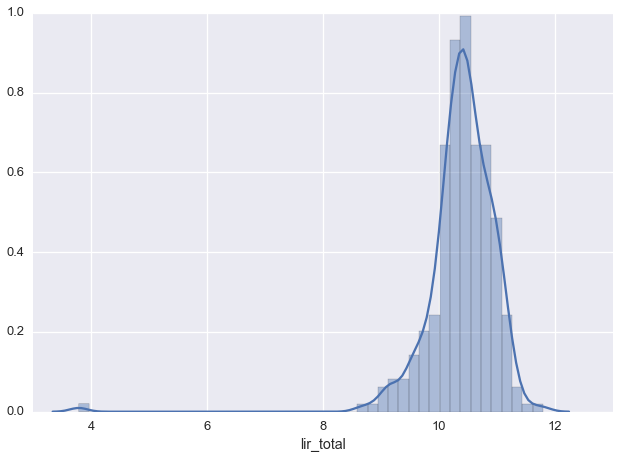

In [3]:
sn.distplot(bat_fits['lir_total'])

While looking through the SED plots, I noticed some sources were not fit well and determined that these had bad photometry and/or shouldn't have been fit. These included one source (Mrk 3) that didn't have any WISE data so the MIR powerlaw component was completely unconstrained and the 6 radio loud AGN we found in the SPIRE catalog (Pictor A, 2MASXJ02327, PKS2331, 3C111, 3C120, and HB89). Further there were some sources where I suspect we weren't capturing all of the emission in the PACS images because the field of view was too small. I'm going to remove these sources from any analysis moving forward so they don't mess things up. Mrk 3 is the reason the above distribution skews all the way to $10^{4}\,L_{\odot}$.

In [4]:
# Remove sources where the fit was bad
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3', 'IC1657', 'IC2461',
                        'MCG-01-05-047', 'NGC788', 'NGC2655',
                        'NGC3718', 'NGC4939', 'NGC4941',
                        'NGC5033', 'NGC4235'])
bat_fits = bat_fits.drop(bad_sources)

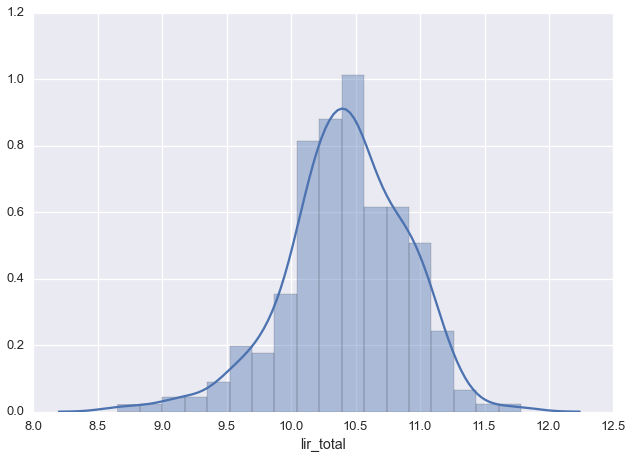

In [5]:
# Lets redo total luminosity distribution
sn.distplot(bat_fits['lir_total'])

Looks like a Gaussian distribution with a slight tail towards low luminosity. Median looks to be out $10^{10.4} L_{\odot}$ with a spread of about 1.0 dex. Let's confirm this.

In [6]:
print 'Median LIR = ', bat_fits['lir_total'].median()
print 'Sigma LIR = ', bat_fits['lir_total'].std()

Median LIR =  10.43576349
Sigma LIR =  0.46724603807


Now lets break it up into the two components: LBB and LPL which are the greybody and powerlaw components.

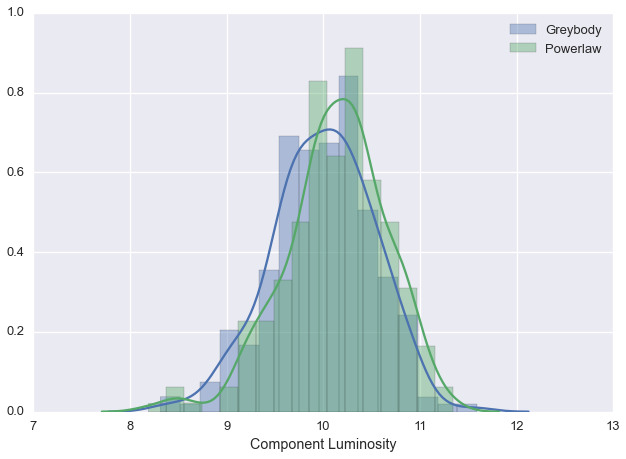

In [7]:
ax = sn.distplot(bat_fits['lir_bb'])
sn.distplot(bat_fits['lir_powlaw'])
ax.set_xlabel('Component Luminosity')
ax.legend(['Greybody', 'Powerlaw'])

The two components contain almost equal amounts of luminosity with the powerlaw component actually slightly higher than the greybody component. Very different from what we saw for the HRS galaxies.

In [8]:
print 'Median Greybody LIR = ', bat_fits['lir_bb'].median()
print 'Sigma Greybody LIR = ', bat_fits['lir_bb'].std()
print ''
print 'Median Powerlaw LIR = ', bat_fits['lir_powlaw'].median()
print 'Sigma Powerlaw LIR = ', bat_fits['lir_powlaw'].std()

Median Greybody LIR =  10.00971096
Sigma Greybody LIR =  0.526041673596

Median Powerlaw LIR =  10.15062739
Sigma Powerlaw LIR =  0.527610825764


With a median greybody LIR of 10.0 and powerlaw LIR of 10.2 it looks like the median ratio between is about $10^{-0.2} \sim 0.6$. Let's look at the distribution of the ratio.

In [9]:
bat_fits['LIR_ratio'] = 10**bat_fits['lir_bb']/10**bat_fits['lir_powlaw']

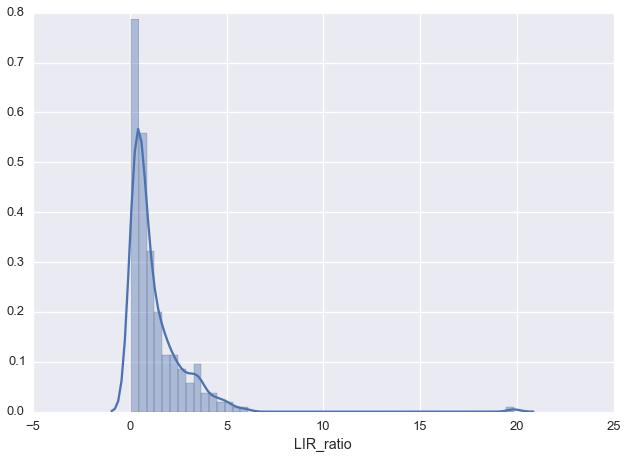

In [10]:
sn.distplot(bat_fits['LIR_ratio'])

In [11]:
print 'Median LIR ratio = ', bat_fits['LIR_ratio'].median()
print 'Sigma LIR ratio = ', bat_fits['LIR_ratio'].std()

Median LIR ratio =  0.721366865469
Sigma LIR ratio =  1.66516917868


Looks like most of the galaxies have quite a low LIR ratio near 1.0 but there is one source that causing the plot to go all the way to LIR ratio = 20. Lets see which source it is.

In [12]:
np.argmax(bat_fits['LIR_ratio'])

'CenA'

Cen A looks to be the AGN that has the highest LIR ratio. This is the nearest galaxy and I suspect what is happening is that the WISE fluxes didn't capture all of the galaxy, making the normalization of the MIR component too low. I'm going to remove this source as well.

In [13]:
bat_fits = bat_fits.drop('CenA')

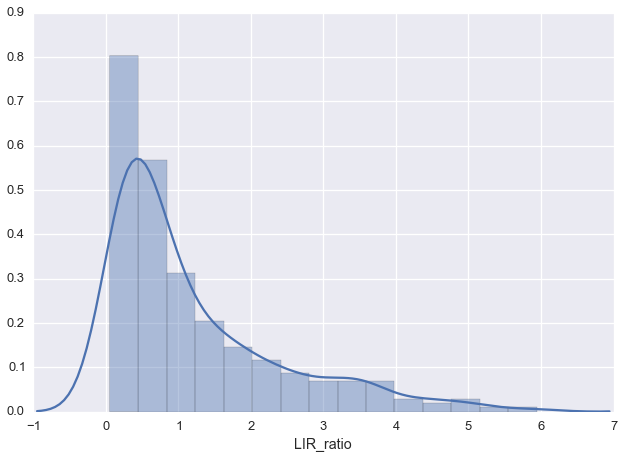

In [14]:
sn.distplot(bat_fits['LIR_ratio'])

In [15]:
print 'Median LIR ratio = ', bat_fits['LIR_ratio'].median()
print 'Sigma LIR ratio = ', bat_fits['LIR_ratio'].std()

Median LIR ratio =  0.716999859371
Sigma LIR ratio =  1.20267467074


Much better looking plot. Again it looks like most of the sources have an LIR ratio less than 1.0 meaning there is more luminosity in the MIR powerlaw component than the greybody component. But there is also a long tail up to LIR ratio of 6.0.

One thing we learned by looking at the Casey 2012 fits for the HRS galaxies is that for non-AGN galaxies, the LIR ratio is a fairly constant $3.0\pm0.8$. That means that to determine the AGN fraction in our BAT AGN, we need to subtract $1/3L_{\rm BB}$ from $L_{\rm PL}$ to get an estimate of the AGN related luminosity. Then we divide by the total luminosity for the AGN fraction. This was done already when putting together the table of best fit results for the BAT AGN and is contained in the column labelled 'agn_frac.'

Let's look at the distribution of AGN fractions.

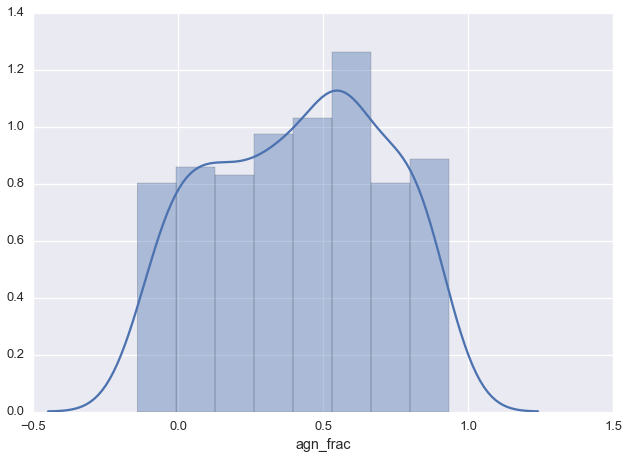

In [16]:
sn.distplot(bat_fits['agn_frac'])

In [17]:
print 'Median AGN fraction = ', bat_fits['agn_frac'].median()
print 'Sigma AGN fraction = ', bat_fits['agn_frac'].std()

Median AGN fraction =  0.443219997
Sigma AGN fraction =  0.294017082203


It almost looks like a fairly uniform distribution with values from 0 all the way up to almost 1.0. It looks like there is possibly a peak around 0.6 but its not very distinct. There are also some sources that have a negative AGN fraction. This is due to correction factor for determining it by subtracting 1/3 the greybody luminosity. Obviously the 1/3 correction factor isn't going to work for all of the sources so sometimes we obviously subtracted too much or even too little. For the sources that have a negative AGN fraction, we'll have to use an upper limit.

Let's look at the $T_{dust}$ and $M_{dust}$ distributions to get an idea of the properties of the sample.

In [18]:
print 'Median Tdust = ', bat_fits['tdust'].median()
print 'Sigma Tdust = ', bat_fits['tdust'].std()
print ''
print 'Median Mdust = ', bat_fits['mdust'].median()
print 'Sigma Mdust = ', bat_fits['mdust'].std()

Median Tdust =  23.90074911
Sigma Tdust =  4.3022203098

Median Mdust =  7.4680343225
Sigma Mdust =  0.564578052179


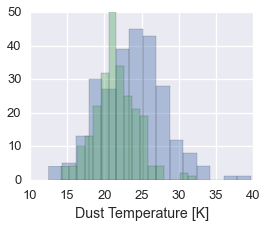

In [19]:
fig = plt.figure(figsize=(4,3))
sn.distplot(bat_fits['tdust'], kde=False)
sn.distplot(hrs_fits['tdust'], kde=False)
plt.xlabel('Dust Temperature [K]')
#fig.savefig('/Users/ttshimiz/Dropbox/Research/Talks/CFA_Oct15/tdust.eps', bbox_inches='tight')

(5.0, 9.0)

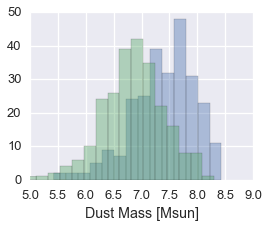

In [20]:
fig = plt.figure(figsize=(4,3))
sn.distplot(bat_fits['mdust'], kde=False)
sn.distplot(hrs_fits['mdust'], kde=False)
plt.xlabel('Dust Mass [Msun]')
plt.xlim(5.0, 9.0)
#fig.savefig('/Users/ttshimiz/Dropbox/Research/Talks/CFA_Oct15/mdust.eps', bbox_inches='tight')

So the average dust temperature is about 24 K and the dust mass is about $10^{7.5}$ solar masses. These are a little bit higher than what we were seeing with the HRS galaxies which had a median dust temperature of 21 K and dust mass of $10^{7}$ solar masses. Of course we will have to make sure we are comparing the two using the same stellar masses.

Finally I want to look at the distribution of $\alpha$ and see how it compares to the HRS.

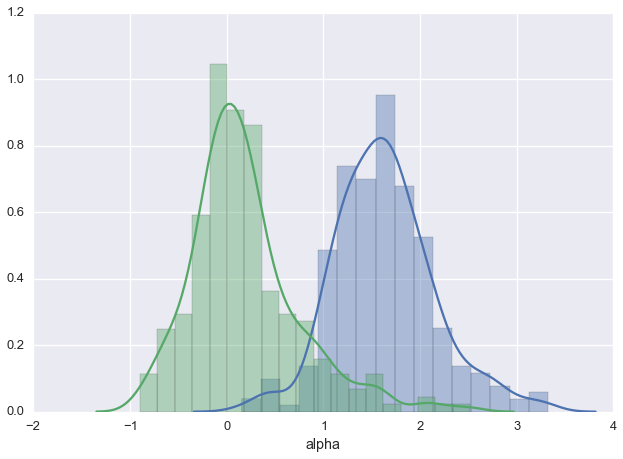

In [21]:
sn.distplot(bat_fits['alpha'])
sn.distplot(hrs_fits['alpha'])

In [22]:
print 'Median alpha = ', bat_fits['alpha'].median()
print 'Sigma alpha = ', bat_fits['alpha'].std()

Median alpha =  1.585878986
Sigma alpha =  0.515742811024


So it looks like a Gaussian distribution with a peak around $\alpha=1.5$ and a spread of about 0.5. This is in stark contrast to the HRS galaxies which had an average $\alpha$ around 0.1 so the MIR is much steeper in the BAT AGN than normal galaxies. 

Lets look at the correlation between AGN fraction and $\alpha$. 

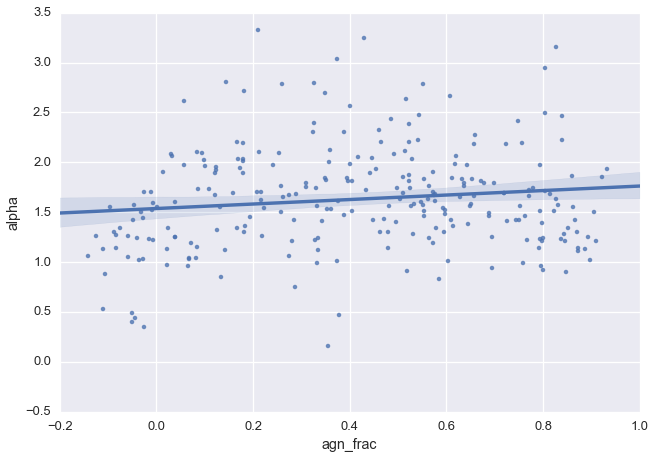

In [23]:
ax = sn.regplot(bat_fits['agn_frac'], bat_fits['alpha'])

It doesn't look like there is really any correlation at all. The scatter plot is quite flat. What about $\alpha$ and the dust temperature?

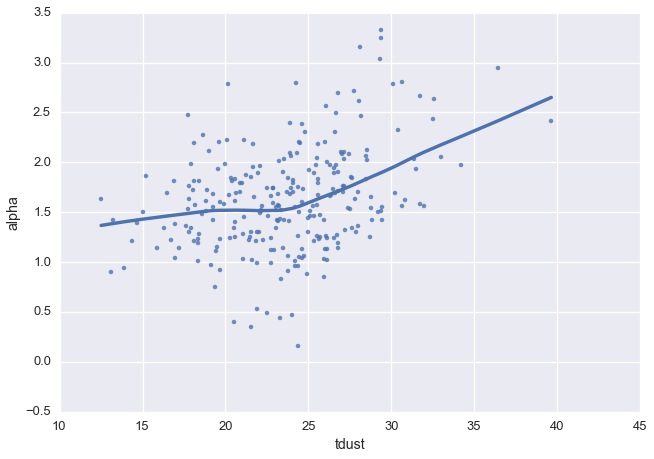

In [24]:
ax = sn.regplot(bat_fits['tdust'], bat_fits['alpha'], lowess=True)

Here there does seem to be some kind of correlation. There is a noticeable upturn in the relationship above a dust temperature of 25 K that goes to higher $\alpha$. 

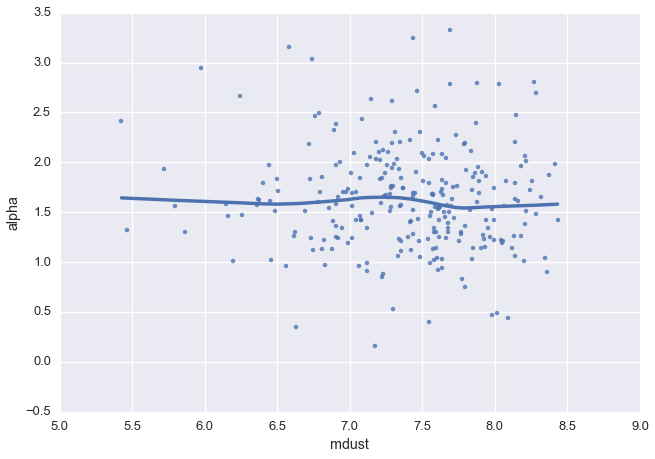

In [25]:
ax = sn.regplot(bat_fits['mdust'], bat_fits['alpha'], lowess=True)

$\alpha$ is certainly not related to the dust mass just like for the HRS galaxies, however it does seem to be a bit related to the dust temperature. I wonder if this is real or related to some of the degeneracy in the model.

Of course one of the first things we want to know is how the AGN fraction is related to the AGN luminosity. For this we'll just use the BAT 14-195 keV luminosity as a proxy for the AGN bolometric luminosity. 

In [26]:
bat_flux = pd.read_csv('/Users/ttshimiz/Github/bat-data/bat_bat_flux.csv', index_col=0)
bat_info = pd.read_csv('/Users/ttshimiz/Github/bat-data/bat_info.csv', index_col=0)

In [27]:
bat_fits['LBAT'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']

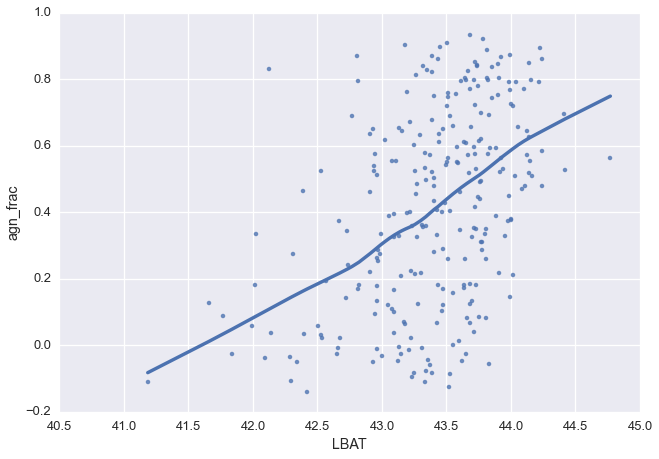

In [28]:
sn.regplot(x=np.log10(bat_fits['LBAT']), y=bat_fits['agn_frac'], lowess=True)

There doesn't seem to be too strong of a relationship between the AGN luminosity and AGN IR fraction. If there is one there is lots of scatter in the relationship. This is likely related to two things: differences in geometry between sources and possibly time variability.

What about a relationship between the dust temperature and AGN luminosity? There really shoudn't be one if the majority of the dust is associated with the ISM of the galaxy but lets just make sure.

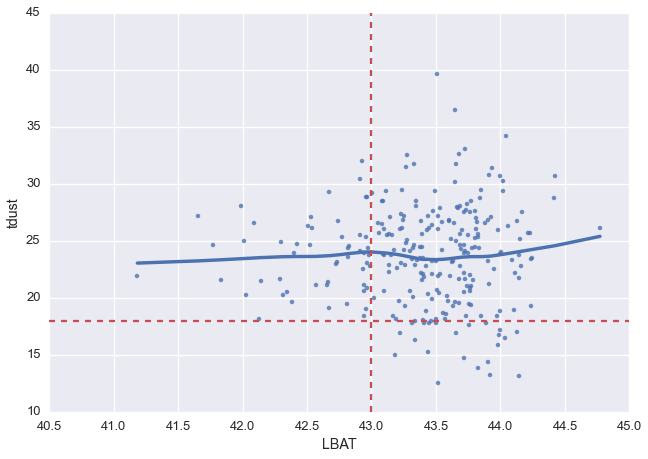

In [29]:
ax = sn.regplot(x=np.log10(bat_fits['LBAT']), y=bat_fits['tdust'], lowess=True)
ax.axhline(18, color='r', ls='dashed')
ax.axvline(43.0, color='r', ls='dashed')

Nope not really any kind of relationship. Although it does seem like many of the sources with a very cold dust temperature ($T_{dust} < 18$ K) have a high AGN luminosity ($L_{\rm BAT} > 10^{43}$ ergs s$^{-1}$). It would be interesting to see what is going on with these sources.

In [30]:
ind_coldDust_strongAGN = bat_fits['tdust'] < 18
bat_fits[ind_coldDust_strongAGN]

,agn_frac,agn_frac_16,agn_frac_84,alpha,alpha_16,alpha_84,lir_bb,lir_bb_16,lir_bb_84,lir_powlaw,...,norm_pow_16,norm_pow_84,tdust,tdust_16,tdust_84,wturn,wturn_16,wturn_84,LIR_ratio,LBAT
Name,,,,,,,,,,,,,,,,,,,,,
2MASXJ13411287-1438407,0.872147,0.845467,0.881722,1.141629,0.785567,1.575257,9.653846,9.619739,9.739334,10.628293,...,-0.454020,-0.180115,17.171857,16.027700,18.478386,49.882841,41.905387,60.707415,0.106060,9.863157e+43
2MASXJ19380437-5109497,0.613644,0.589324,0.662860,1.360582,1.066585,1.743145,9.663658,9.593864,9.683417,10.053010,...,-0.857619,-0.640294,17.598026,16.452937,19.007787,55.249131,45.369702,68.499965,0.407988,5.652214e+43
ARK241,0.845837,0.779435,0.886175,1.206716,0.903888,1.576417,9.402876,9.276584,9.552313,10.286473,...,-0.699146,-0.479864,14.380043,12.456381,16.759605,54.998674,46.293898,67.768042,0.130738,7.964590e+43
CGCG102-048,0.562255,0.517646,0.622353,1.636977,1.385316,1.975344,9.116214,9.020713,9.149782,9.427101,...,-0.954575,-0.803468,12.501083,11.532944,13.546996,64.282535,53.407367,77.706283,0.488780,3.275532e+43
CGCG300-062,0.503149,0.451245,0.554314,1.634527,1.372218,1.983207,9.610850,9.554743,9.649317,9.837080,...,-0.755942,-0.601673,17.813420,16.757826,19.048747,59.511583,49.575497,72.433213,0.593977,2.544344e+43
CGCG535-012,0.866488,0.826129,0.898174,1.419857,1.160361,1.746596,9.560011,9.439179,9.685500,10.513606,...,-0.461089,-0.318218,13.231019,11.852784,14.629677,60.267849,50.944222,72.764782,0.111277,8.368868e+43
ESO031-G008,0.577290,0.454859,0.643169,1.340770,1.047809,1.703642,9.348238,9.273087,9.489872,9.681535,...,-0.917866,-0.686622,16.314050,14.486325,18.590320,57.031110,46.055101,69.913231,0.464198,2.170836e+43
ESO121-IG028,0.510227,0.355130,0.611340,1.697279,1.221096,2.333124,9.597432,9.491822,9.767068,9.833554,...,-1.108896,-0.798077,16.502237,14.497628,18.623712,39.806298,26.694063,55.446926,0.580601,1.079237e+44
ESO426-G002,0.635473,0.555239,0.642180,1.765316,1.317257,2.268974,9.638394,9.635938,9.761959,10.062901,...,-0.291342,-0.051386,17.782761,15.137187,20.050746,41.615390,32.448235,51.904787,0.376264,2.795323e+43


Interestingly all of these sources, except for two (ESO511-G030 and ESO533-G050) have AGN fractions greater 35% and many of them have AGN fractions greater 50%. 

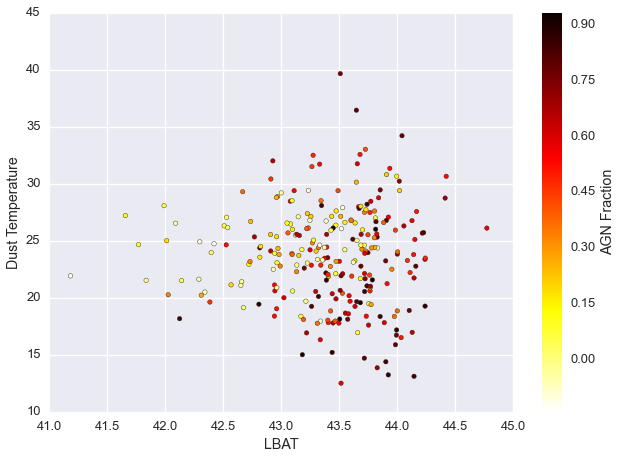

In [31]:
sc = plt.scatter(np.log10(bat_fits['LBAT']), bat_fits['tdust'], c=bat_fits['agn_frac'], cmap='hot_r')
cb = plt.colorbar(sc)
cb.set_label('AGN Fraction')
plt.xlabel('LBAT')
plt.ylabel('Dust Temperature')

It does seem like most of the galaxies with high AGN fraction have a lower dust temperature. Lets break up the BAT AGN into two groups, one with AGN fraction above 50% and one with AGN fraction below 50%. 

In [32]:
high_af = bat_fits['agn_frac'] > 0.5
low_af = bat_fits['agn_frac'] < 0.5

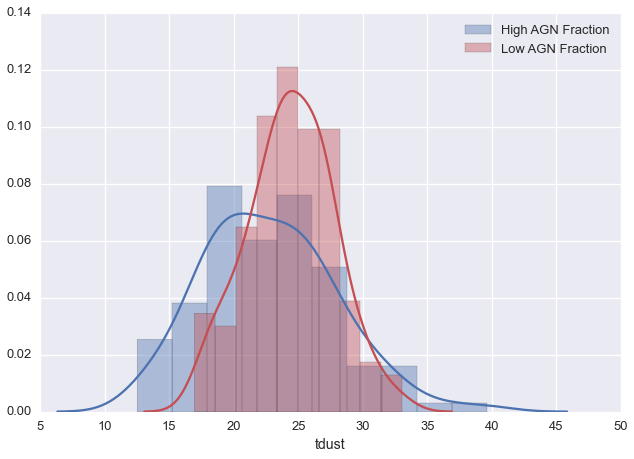

In [33]:
sn.distplot(bat_fits['tdust'][high_af])
sn.distplot(bat_fits['tdust'][low_af], color='r')
plt.legend(['High AGN Fraction', 'Low AGN Fraction'])

Indeed it seems like the sources with a higher AGN fraction do skew towards lower dust temperatures compared to the ones with a lower AGN fraction. It will be interesting to compare these distributions to the dust temperature distribution for the HRS galaxies.

One last thing I want to test is the relationship between the AGN luminosity and the AGN related IR emission as well as the star-forming luminosity. For this we need to calculate the AGN related IR emission and star-forming luminosity by using the 1/3 correction factor like we did when we calculated the AGN fraction.

In [34]:
bat_fits['LAGN_IR'] = 10**(bat_fits['lir_powlaw']) - 1./3.*(10**(bat_fits['lir_bb']))
bat_fits['LSF'] = 4./3.*10**(bat_fits['lir_bb'])

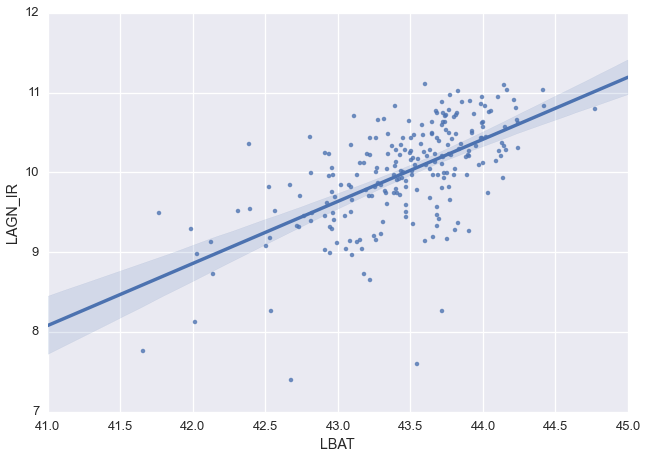

In [35]:
sn.regplot(np.log10(bat_fits['LBAT']), np.log10(bat_fits['LAGN_IR']))

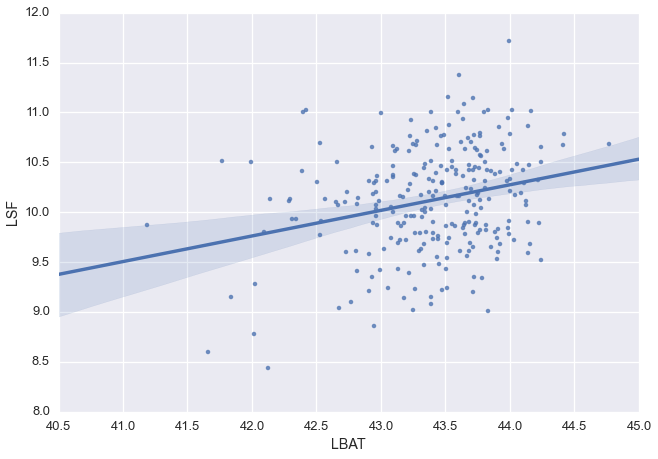

In [36]:
sn.regplot(np.log10(bat_fits['LBAT']), np.log10(bat_fits['LSF']))

There's definitely a much better correlation between the BAT luminosity and the AGN IR luminosity compared to the star-forming luminosity. However the correlation is certainly not as strong as would have hoped for. Again I wonder if this is due to geometrical effects as well as time variability. 

Last thing I want to look at is the correlation coefficients for each of these relationships. For that I'll need the scipy package.

In [37]:
from scipy.stats import spearmanr, pearsonr

In [38]:
ind_use = bat_fits['LAGN_IR'] > 0
lbat_lagnIR_spearman = spearmanr(np.log10(bat_fits['LBAT'][ind_use]), np.log10(bat_fits['LAGN_IR'][ind_use]))
lbat_lsf_spearman = spearmanr(np.log10(bat_fits['LBAT']), np.log10(bat_fits['LSF']))

lbat_lagnIR_pearson = pearsonr(np.log10(bat_fits['LBAT'][ind_use]), np.log10(bat_fits['LAGN_IR'][ind_use]))
lbat_lsf_pearson = pearsonr(np.log10(bat_fits['LBAT']), np.log10(bat_fits['LSF']))

In [40]:
print 'Spearman Rank Correlation Coefficients:'
print 'LBAT vs LAGN_IR: ', lbat_lagnIR_spearman[1]
print 'LBAT vs LSF: ', lbat_lsf_spearman[1]
print ''
print 'Pearson Rank Correlation Coefficients:'
print 'LBAT vs LAGN_IR: ', lbat_lagnIR_pearson[0]
print 'LBAT vs LSF: ', lbat_lsf_pearson[0]

Spearman Rank Correlation Coefficients:
LBAT vs LAGN_IR:  1.43623442547e-25
LBAT vs LSF:  0.000439715108729

Pearson Rank Correlation Coefficients:
LBAT vs LAGN_IR:  0.612808419381
LBAT vs LSF:  0.263019399171


Clearly there is a much stronger correlation between the AGN IR related emission than the star-forming related emission no matter which type of correlation coefficient you use. One that I haven't done here though is to include any of the sources that we didn't fit, i.e. the ones that didn't have enough data to be fit with the model. It would be interesting to see if those change the correlations at all.

In [45]:
bat_fits['SFR'] = bat_fits['LSF']*3.846e33/2.57e43

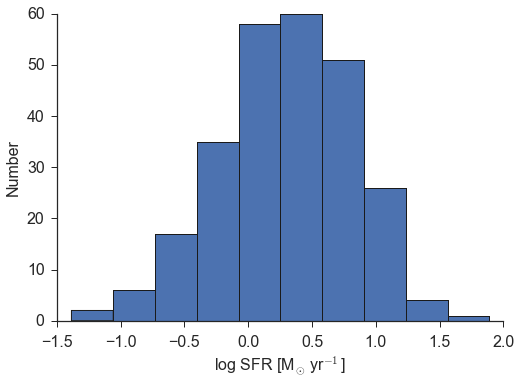

In [56]:
#sn.distplot(np.log10(bat_fits['SFR']), kde=False, )
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
plt.hist(np.log10(bat_fits['SFR']), color='b', lw=1.0)
plt.xlabel('log SFR [M$_{\odot}$ yr$^{-1}$]', fontsize=16)
plt.ylabel('Number', fontsize=16)
sn.despine()
plt.savefig('/Users/ttshimiz/Dropbox/Research/Talks/CFA_Oct15/sfr.pdf', bbox_inches='tight')

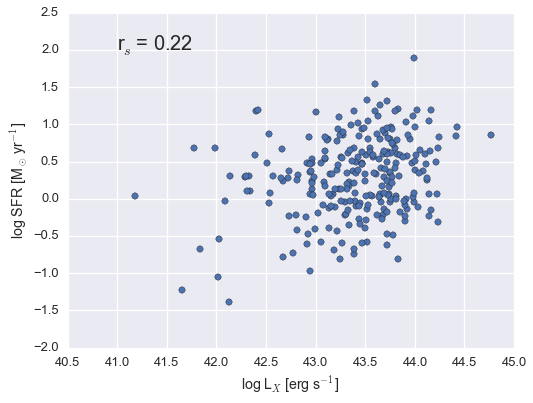

In [59]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(bat_fits['LBAT']), np.log10(bat_fits['SFR']), c='b', s=40)
plt.xlabel('log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel('log SFR [M$_{\odot}$ yr$^{-1}$]')
cc = spearmanr(np.log10(bat_fits['LBAT']), np.log10(bat_fits['SFR']))
plt.text(41.0, 2.0, 'r$_{s}$ = %0.2f' % cc[0], fontsize=20)
plt.savefig('/Users/ttshimiz/Dropbox/Research/Talks/CFA_Oct15/sfr_v_lbat.eps', bbox_inches='tight')

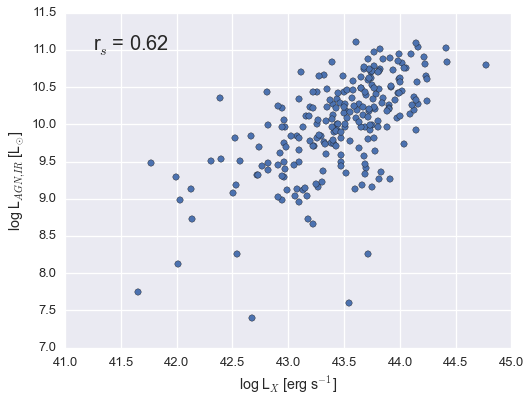

In [63]:
plt.figure(figsize=(8,6))
ind_use = bat_fits['LAGN_IR'] > 0
plt.scatter(np.log10(bat_fits['LBAT']), np.log10(bat_fits['LAGN_IR']), c='b', s=40)
plt.xlabel('log L$_{X}$ [erg s$^{-1}$]')
plt.ylabel('log L$_{AGN, IR}$ [L$_{\odot}$]')
cc = spearmanr(np.log10(bat_fits['LBAT'][ind_use]), np.log10(bat_fits['LAGN_IR'][ind_use]))
plt.text(41.25, 11.0, 'r$_{s}$ = %0.2f' % cc[0], fontsize=20)
plt.savefig('/Users/ttshimiz/Dropbox/Research/Talks/CFA_Oct15/lagn_ir_v_lbat.eps', bbox_inches='tight')